In [ ]:
# Anomaly detection in time series using chatgpt

In [ ]:
# References
[1. anomaly-detection-in-time-series-using-chatgpt](https://medium.com/@sztistvan/anomaly-detection-in-time-series-using-chatgpt-3fc48f958c88)
Related notebook anomaly_detection_chatgpt.ipynb
[2. Change Point Detection in Time Series using ChatGPT](https://medium.com/@sztistvan/change-point-detection-in-time-series-using-chatgpt-22cc9172a130)

In [ ]:
# To perform anomaly detection on this dataset, I’ll be using a simple statistical method called the Moving Average (MA) technique. 
# The MA technique calculates the moving average of the data over a specified time window and detects anomalies based on deviations from the moving 
#average.

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
sns.set()

pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [2]:
# settings
import warnings
warnings.filterwarnings('ignore')
#print all rows of a df in ipython shell 
pd.set_option('display.max_rows', None)
#print all columns of a df in ipython shell 
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option("display.precision", 6)


# optional
pd.set_option('display.max_columns',100)
sns.set_style('darkgrid')

In [ ]:
## TOC:
* [Moving Average method](#ma-bullet)
* [Z-score](#zscore-bullet)
* [Difference between anomaly and change point](#diff-bullet)
* [Types of anomalies](#types-bullet)
* [Algoritms for anomaly detection](#algs-bullet)
* [Isolation Forest](#if-bullet)
* [Local Outlier Factor (LOF)](#lof-bullet)    



In [ ]:
## Moving Average method <a class="anchor" id="ma-bullet"></a>

In [ ]:
# To perform anomaly detection on this dataset, I’ll be using a simple statistical method called the Moving Average (MA) technique. 
# The MA technique calculates the moving average of the data over a specified time window and detects anomalies based on deviations from the moving average.

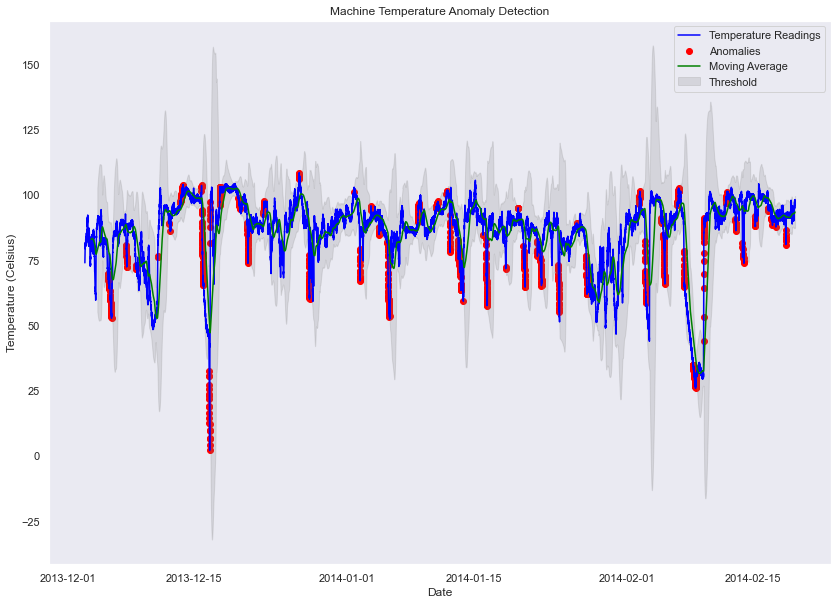

In [4]:
# Reference 1 
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv')

# Convert the timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the moving average of the temperature readings
window_size = 200 # MODIFICATION, original was 50
ma = df['value'].rolling(window_size).mean()

# Calculate the deviation from the moving average
deviation = df['value'] - ma

# Calculate the standard deviation of the deviation
std_deviation = deviation.rolling(window_size).std()

# Calculate the threshold for anomaly detection
threshold = 3 * std_deviation

# Detect anomalies based on deviations from the moving average
anomalies = df[deviation.abs() > threshold]

# Plot the temperature readings and the anomalies
plt.subplots(figsize=(14, 10)) # MODIFICATION, inserted
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies')
plt.plot(df['timestamp'], ma, color='green', label='Moving Average')
plt.fill_between(df['timestamp'], ma-threshold, ma+threshold, color='gray', alpha=0.2, label='Threshold')
plt.legend()
plt.title('Machine Temperature Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid() # MODIFICATION, inserted
plt.show()

In [2]:
anomalies

,timestamp,value
734,2013-12-05 10:25:00,69.693368
737,2013-12-05 10:40:00,69.623285
738,2013-12-05 10:45:00,69.682566
745,2013-12-05 11:20:00,69.058279
749,2013-12-05 11:40:00,68.560754
...,...,...
22397,2014-02-18 14:40:00,83.731850
22398,2014-02-18 14:45:00,82.953906
22399,2014-02-18 14:50:00,80.969539
22400,2014-02-18 14:55:00,82.222039


In [3]:
ma

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
22690    93.310113
22691    93.341778
22692    93.368746
22693    93.392867
22694    93.414094
Name: value, Length: 22695, dtype: float64

In [ ]:
## Z-score <a class="anchor" id="zscore-bullet"></a>

In [ ]:
# If we calculate the deviations from the mean and compare them to the standard deviation of data values then we basically apply Z-score. 
# Z-score gives how many standard deviations away a given value is from the mean of data values.

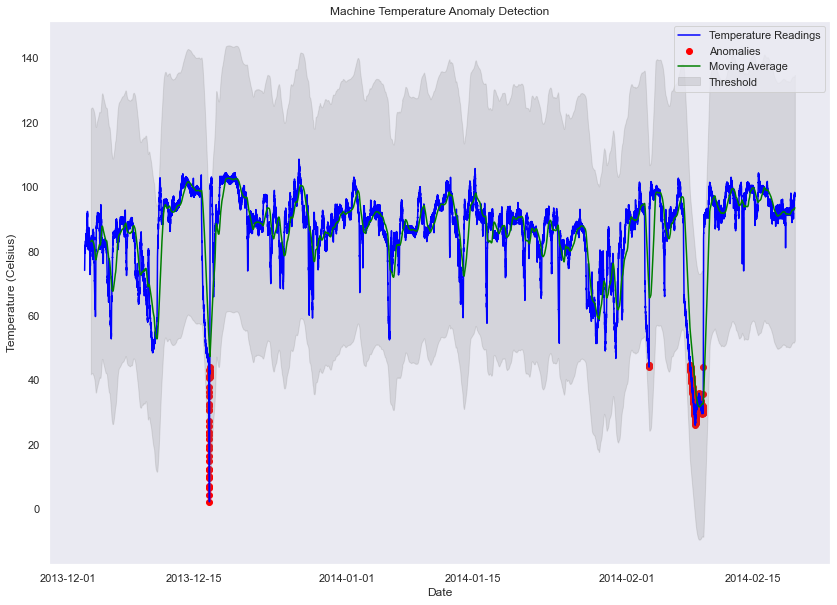

In [5]:
# Calculate the average of the temperature readings
mean = df['value'].mean()

# Calculate the deviation from the average
deviation = df['value'] - mean

# Calculate the standard deviation of the deviation
std_deviation = deviation.std() # same as we would calculate df['value'].std()

# Calculate Z-score - we don't use it directly, for reference only
z_score = deviation / std_deviation # z_score = (value-mean)/std

# Calculate the threshold for anomaly detection
threshold = 3 * std_deviation

# Detect anomalies based on deviations from the moving average
anomalies = df[deviation.abs() > threshold]

# Plot the temperature readings and the anomalies
plt.subplots(figsize=(14, 10)) # MODIFICATION, inserted
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies')
plt.plot(df['timestamp'], ma, color='green', label='Moving Average')
plt.fill_between(df['timestamp'], ma-threshold, ma+threshold, color='gray', alpha=0.2, label='Threshold')
plt.legend()
plt.title('Machine Temperature Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid() # MODIFICATION, inserted
plt.show()

In [ ]:
# Percentiles
# We can set global upper and lower limits separately based on the percentage distribution of data values. Not strictly defining, the percentile indicates 
# that a certain percentage of data points fall below that percentile. For instance, the 50th percentile is the median. To set lower and upper bounds to define
# the outer range of 99.7% of the data we can use the following code block:

In [6]:
# calculate percentile limits
percent_limit = 0.3 # 99.7% is set
upper_threshold = df['value'].quantile((100-percent_limit/2)/100) 
lower_threshold = df['value'].quantile(percent_limit/2/100) 

# Detect anomalies based on percentile limits
anomalies_upper = df[df['value'] > upper_threshold]
anomalies_lower = df[df['value'] < lower_threshold]

In [ ]:
## Difference between anomaly and change point <a class="anchor" id="diff-bullet"></a>

In [ ]:
#Anomaly detection in time series:

#Anomalies can indicate potential problems in the underlying system or process that generates the data.
#It involves identifying data points or events that deviate significantly from the expected or normal behavior of the time series.
#Change point detection in time series:

#Change points can indicate significant transitions in the underlying system or process that generates the data.
#It involves identifying points in time where the statistical properties of the time series change abruptly.
#The main difference is that anomaly detection focuses on identifying individual data points or events that deviate from the normal (or expected) behavior, whereas change point detection focuses on identifying points in time where the statistical properties of the time series change.

In [ ]:
## Types of anomalies <a class="anchor" id="types-bullet"></a>

In [ ]:
#1. Point anomalies: A point anomaly is a single data point that is significantly different from the rest of the data. It can be caused by measurement errors, system malfunctions, or other factors.

#2. Contextual anomalies: Contextual anomalies are data points that are not unusual on their own, but become anomalous in a particular context. For example, a sudden spike in website traffic on a holiday is not unusual, but a similar spike on a regular weekday could be an anomaly.

#3. Collective anomalies: Collective anomalies are groups of data points that are anomalous when considered together. They can be caused by changes in the underlying system or by external factors affecting the system.

#4. Seasonal anomalies: Seasonal anomalies occur when the time series data show regular patterns or cycles, but a particular cycle deviates significantly from the expected pattern. For example, unusually high sales during a non-peak season would be a seasonal anomaly.

#5. Cyclical anomalies: Cyclical anomalies occur when the time series data shows long-term cycles or trends that deviate significantly from the expected pattern. These anomalies are often caused by external factors such as economic recessions or natural disasters.

#Remark: In the definition of collective anomaly, we can recognize the concept of pattern anomaly.

In [ ]:
## Algoritms for anomaly detection <a class="anchor" id="algs-bullet"></a>

In [ ]:
#1. Isolation Forest: it is an unsupervised machine learning algorithm that uses decision trees to isolate anomalies from the rest of the data. It works by randomly partitioning the data into subsets until each data point is isolated in its own partition. The fewer partitions a data point needs to be isolated, the more anomalous it is considered to be.

#2. Local Outlier Factor (LOF): LOF is a density-based anomaly detection algorithm that measures the local density of a point with respect to its neighbors. Points with a lower density than their neighbors are considered to be outliers.

#3. One-Class Support Vector Machine (SVM): One-Class SVM is a type of SVM that is trained on only one class of data. It learns a decision boundary that separates the training data from the origin, and any point on the other side of the boundary is considered an anomaly.

#4. LSTM-based models: Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is well suited for modeling sequential data. LSTM-based models can be trained to detect anomalies in time series data by learning the patterns and relationships in the data over time.

#5. Autoencoder: An autoencoder is a neural network that can be trained to reconstruct the input data. When an anomaly is detected, the reconstructed output will be significantly different from the input data.

#6. ARIMA (AutoRegressive Integrated Moving Average): ARIMA is a time series forecasting method that can be used to detect anomalies. It models the time series as a combination of autoregressive (AR), integrated (I), and moving average (MA) components. Anomalies can be detected by comparing the predicted values with the actual values.

#7. Seasonal Hybrid ESD (S-H-ESD): S-H-ESD is a variant of the ESD algorithm that can be used to detect anomalies in seasonal time series. It takes into account the seasonal patterns in the data and uses a hybrid approach that combines the ESD algorithm with a seasonal decomposition of the time series.

In [ ]:
## Isolation Forest <a class="anchor" id="if-bullet"></a>

In [ ]:
# Isolation Forest belongs to the type of unsupervised machine learning algorithms. It uses an ensemble of decision trees to isolate anomalous points in the data.

In [7]:
import pandas as pd
from sklearn.ensemble import IsolationForest

def detect_anomalies_with_isolation_forest(series):
    # Convert the series to a 2D NumPy array
    data = series.values.reshape(-1, 1)
    
    # Create an instance of the IsolationForest class
    #model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
    model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

    # Fit the model to the data and predict anomalies
    model.fit(data)
    anomalies = model.predict(data)
    
    # Convert the predictions back to a Pandas series and return it
    anomalies_series = pd.Series(anomalies, index=series.index)
    return anomalies_series

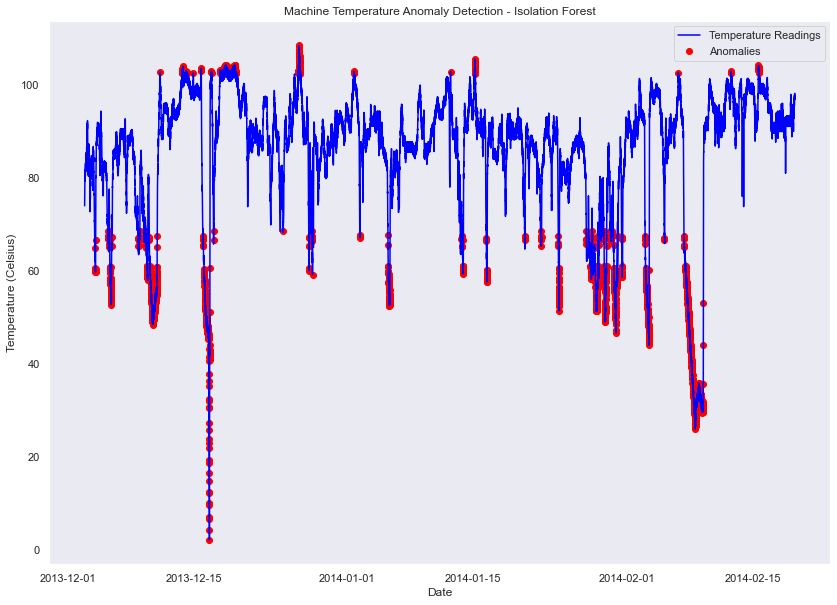

In [9]:
# Set the timestamp column as the index and convert to a series
series = df.set_index('timestamp')['value'].squeeze()

# Detect anomalies using the Isolation Forest algorithm
anomalies = detect_anomalies_with_isolation_forest(series)

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10)) 
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies[anomalies==-1].index, series[anomalies==-1].values, color='red', label='Anomalies')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

# We can observe that, unlike the Z-score method, detected points can be better matched to local differences.

In [ ]:
## Local Outlier Factor <a class="anchor" id="lof-bullet"></a>

In [ ]:
Local Outlier Factor
# Local Outlier Factor (LOF) is an unsupervised machine learning algorithm for anomaly detection that works by measuring the local density of each data point and comparing it to the densities of its neighbors. It is based on the idea that anomalous data points are often located in low-density regions of the feature space.

In [10]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

def detect_anomalies_with_local_outlier(series):
    #lof = LocalOutlierFactor(n_neighbors=10, contamination='auto')
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.01)
    X = series.values.reshape(-1,1)
    y_pred = lof.fit_predict(X)
    anomalies = X[y_pred==-1]
    return pd.Series(anomalies.flatten(), index=series.index[y_pred==-1])

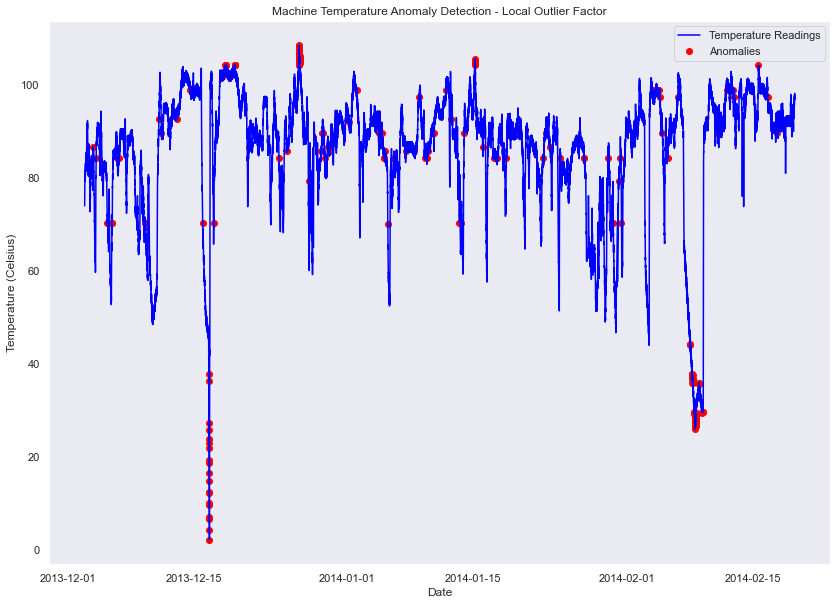

In [11]:
# Detect anomalies using the Local Outlier Factor algorithm
anomalies = detect_anomalies_with_local_outlier(series)

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10)) 
plt.plot(df['timestamp'], df['value'], color='blue', label='Temperature Readings')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - Local Outlier Factor')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

In [ ]:
## Autoencoder <a class="anchor" id="autoencoder-bullet"></a>

In [ ]:
# to be copied checked from original notebook

In [ ]:
## Arima <a class="anchor" id="arima-bullet"></a>

In [ ]:
# ARIMA (Autoregressive Integrated Moving Average) is a linear modelling technique that models time series data as a mixture of autoregressive (AR) and moving average (MA) components, applied mainly to make predictions in time series data.